In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import cosima_cookbook as cc
import xarray as xr
import xrft
import cftime

from netCDF4 import Dataset

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from matplotlib.gridspec import GridSpec

from matplotlib import rc

rc('font',**{'family':'sans-serif'})
rc('text', usetex=False)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12) 
rc('axes', labelsize=14)    # fontsize of the x and y labels

import cmocean

import dask
from dask.distributed import Client

import cartopy
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.feature as cft
import cartopy.feature as cfeature

import math
import string
import scipy
import numpy as np
import xesmf as xe

import eofs
from eofs.xarray import Eof

In [3]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:34555 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 12 Memory: 48.00 GiB


## Load data saved with `prepare-raw-data.ipynb`

First set the `depths_integrated` string which denotes the depths we integrated the heat to obtain upper-ocean heat content.

In [4]:
depths_integrated = '0m-50m'

Now load all `ssh` fields (model and observations).

In [5]:
ssh_1_RYF = xr.open_mfdataset('output/ssh-1deg-RYF-regridded/*.nc', combine='by_coords', parallel=True)
ssh_1_RYF = ssh_1_RYF.sea_level

ssh_1_IAF = xr.open_mfdataset('output/ssh-1deg-IAF-regridded/*.nc', combine='by_coords', parallel=True)
ssh_1_IAF = ssh_1_IAF.sea_level

ssh_025_RYF = xr.open_mfdataset('output/ssh-025deg-RYF-regridded/*.nc', combine='by_coords', parallel=True)
ssh_025_RYF = ssh_025_RYF.sea_level

ssh_025_IAF = xr.open_mfdataset('output/ssh-025deg-IAF-regridded/*.nc', combine='by_coords', parallel=True)
ssh_025_IAF = ssh_025_IAF.sea_level

ssh_010_RYF = xr.open_mfdataset('output/ssh-010deg-RYF-regridded/*.nc', combine='by_coords', parallel=True)
ssh_010_RYF = ssh_010_RYF.sea_level

ssh_010_IAF = xr.open_mfdataset('output/ssh-010deg-IAF-regridded/*.nc', combine='by_coords', parallel=True)
ssh_010_IAF = ssh_010_IAF.sea_level

In [6]:
ssh_cmems = xr.open_mfdataset('output/cmems-monthlymean-regridded/*.nc', combine='by_coords', parallel=True)
ssh_cmems = ssh_cmems.ssh
ssh_cmems = ssh_cmems.rename('adt')

and then all `uohc` fields (defined over the `depths_integrated`),

In [7]:
uohc_1_RYF = xr.open_mfdataset('output/uohc-1deg-'+depths_integrated+'-RYF/*.nc', combine='by_coords', parallel=True)
uohc_1_RYF = uohc_1_RYF.uohc

uohc_025_RYF = xr.open_mfdataset('output/uohc-025deg-'+depths_integrated+'-RYF/*.nc', combine='by_coords', parallel=True)
uohc_025_RYF = uohc_025_RYF.uohc

uohc_010_RYF = xr.open_mfdataset('output/uohc-010deg-'+depths_integrated+'-RYF/*.nc', combine='by_coords', parallel=True)
uohc_010_RYF = uohc_010_RYF.uohc

uohc_1_IAF = xr.open_mfdataset('output/uohc-1deg-'+depths_integrated+'-IAF/*.nc', combine='by_coords', parallel=True)
uohc_1_IAF = uohc_1_IAF.uohc

uohc_025_IAF = xr.open_mfdataset('output/uohc-025deg-'+depths_integrated+'-IAF/*.nc', combine='by_coords', parallel=True)
uohc_025_IAF = uohc_025_IAF.uohc

uohc_010_IAF = xr.open_mfdataset('output/uohc-010deg-'+depths_integrated+'-IAF/*.nc', combine='by_coords', parallel=True)
uohc_010_IAF = uohc_010_IAF.uohc

## Useful functions for analysis

First, we define some functions that we will use for analyzing the data.

In [8]:
def process_detrend(ar):
    """Removes the linear trend of `ar`."""

    ar = ar.copy()
    ar_detrend = scipy.signal.detrend(ar)
    
    return ar_detrend

def detrend_datarray(da):
    """Removes the linear trend of xarray dataarray `da`."""
    
    da_detrend = xr.apply_ufunc(
        process_detrend, da.fillna(0),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask = "allowed")

    # now put nans back to where they belong..
    da_detrend = da_detrend.where(np.isfinite(da), np.nan)
    da_detrend = da_detrend + da.mean(dim='time')
    da_detrend = da_detrend.chunk(chunks='auto')
    
    return da_detrend

In [9]:
def analysisfft(da, freqperyear=12):
    """Computes the Fourier transform in time for a data-array da and returns the square absolute value of the Fourier transform.

    Parameters:
    freqperyear (Int): Integer denoting the sampling of the time series per year. E.g., monthly output corresponds to `freqperyear=12`.

    Returns:
    da_hat_abs2: The square absolute value of the Fourier-transform in time of the time-mean anomaly of da."""

    da_anomaly = da - da.mean(dim='time')
    da_anomaly = da_anomaly.rename(da.name+'_anomaly')
    
    da_anomaly = da_anomaly.assign_coords(time=np.arange(da.time.size)) # replaces time with time-index
    da_anomaly = da_anomaly.chunk({'time':None}) # makes sure time dimension in not chunked

    da_anomaly_hat_abs2 = np.abs(xrft.dft(da_anomaly, dim=['time'], real='time', window=False, detrend=None) / da_anomaly.time.size)**2
    da_anomaly_hat_abs2 = da_anomaly_hat_abs2.rename('transform_of_mean_' + da_anomaly.name)
    da_anomaly_hat_abs2.attrs['long_name'] = 'Abs value squared of Fourier transform of ' + da_anomaly.name
    
    da_anomaly_hat_abs2['freq_time'] = da_anomaly_hat_abs2.freq_time*freqperyear
#     da_anomaly_hat_abs2['freq_time_spacing'] = da_anomaly_hat_abs2.freq_time_spacing*freqperyear

    return da_anomaly_hat_abs2

def averagefftspec(dahat, lower_range=1/25, upper_range=12/18):
    """Computes the average of a Fourier transform in time for the frequency ranges ϵ [lower_range, upper_range] cycles per year.

    Parameters:
    lower_range (Float): The lower part of the range which the Fourier transform singal is averaged on (in cycles per year)
    upper_range (Float): The lower part of the range which the Fourier transform singal is averaged on (in cycles per year)
    
    Returns:
    dahat_av: The average of a Fourier transform in time for the frequency ranges ϵ [lower_range, upper_range] cycles per year."""

    dahat_av = dahat.sel(freq_time=slice(lower_range, upper_range)).sum(dim='freq_time')
    dahat_av = dahat_av.where(np.isfinite(dahat.isel(freq_time=0)), np.nan)
    
    # The factor 2 was required to correct the amplitude of spectrum when real-FFT are used 
    # in the xrft version we used for this notebook. Latest releases of xrft return the correct
    # spectral amplitude when real FFTs are done and there is no need to multiply by 2.
    return 2*dahat_av

In [10]:
def remove_highfreq(da, lower_range=1/25, upper_range=12/18, freqperyear=12):
    """Extracts the low-frequency component of data-array `da`. The low-frequency component here is defined as all
    frequencies in the range ϵ [`lower_range`, `upper_range`] (in cycles per year).

    Parameters:
    lower_range (Float): The lower part of the range which the Fourier transform singal is averaged on (in cycles per year)
    upper_range (Float): The lower part of the range which the Fourier transform singal is averaged on (in cycles per year)
    freqperyear (Float): The time-resolution of dataarray `da`. For monthly data freqperyear=12, for annual data, freqperyear=1, etc.
    
    Returns:
    da_lowfreq: The low-frequency component of data-array `da` for frequency range ϵ [`lower_range`, `upper_range`] (in cycles per year)."""

    array = da.values
    time = np.arange(array.shape[0]) / freqperyear
    arrayhat = np.fft.rfft(array, axis=0)
    freq = freqperyear / array.shape[0] * np.arange(arrayhat.shape[0])
    
    arrayhat0 = arrayhat[0].copy()
    
    # filter out anything outside frequency range ϵ [lower_range, upper_range]
    arrayhat[freq > upper_range] = 0
    arrayhat[freq < lower_range] = 0
    
    arrayhat[0] = arrayhat0
    
    array_lowfreq = np.fft.irfft(arrayhat, axis=0)
    
    da_lowfreq = da.copy()
    da_lowfreq.data = array_lowfreq
    da_lowfreq = da_lowfreq.rename(da.name+'_lowfreq')
    
    return da_lowfreq

In [11]:
def sphere_integral(da):
    """Computes the surface integral of data array `da` over the globe.
    `da` is given in `lon`, `lat` cordinates in degrees.
    The factor (π/180)² converts degrees to radians.

    Returns: ∬ da(lon, lat, extradims...) cos(lat) dlat dlon."""
    
    earth_radius = 6371e3 # meters
    
    return (da * earth_radius**2 * (np.pi / 180)**2 * np.cos((np.deg2rad(da.latitude)))).fillna(0.).integrate('latitude').integrate('longitude')

def sphere_average(da):
    """Compute the mean of data array `da` over the globe.
    `da` is given in `lon`, `lat` cordinates in degrees.

    Returns: ∬ da(lon, lat, extradims...) cos(lat) dlat dlon / ∬ cos(lat) dlat dlon."""
    
    return sphere_integral(da) / sphere_integral(1. + 0*da)

## Analysis

Now let's analyse some data!

First, because the satellite altimetry record is short (only 27 years), we remove any linear trend from every point.

In [12]:
ssh_cmems_detrended = detrend_datarray(ssh_cmems)
ssh_cmems_detrended = ssh_cmems_detrended.transpose('time', 'latitude', 'longitude')
ssh_cmems_detrended

<xarray.DataArray 'adt' (time: 324, latitude: 180, longitude: 360)>
dask.array<transpose, shape=(324, 180, 360), dtype=float64, chunksize=(252, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-12-01
  * longitude  (longitude) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5

Now we define upper and lower cutoff frequencies for extracting the low-frequency component of our fields. The function above expect the frequencies in units `years⁻¹`.

In [13]:
lower_range = 1/25   # years⁻¹
upper_range = 12/18  # years⁻¹

(To reproduce some of the sensitivity analysis regarding robustness of our results with respect to the choice of frequency cutoffs above, one needs to change the values above and repeat the analyses.)

Let's use `remove_highfreq` function to compute the low-frequency component of our fields.

In [14]:
ssh_cmems_detrended_LF = remove_highfreq(ssh_cmems_detrended, freqperyear=12, lower_range=lower_range, upper_range=upper_range)

ssh_1_IAF_LF   = remove_highfreq(ssh_1_IAF  , freqperyear=12, lower_range=lower_range, upper_range=upper_range)
ssh_025_IAF_LF = remove_highfreq(ssh_025_IAF, freqperyear=12, lower_range=lower_range, upper_range=upper_range)
ssh_010_IAF_LF = remove_highfreq(ssh_010_IAF, freqperyear=12, lower_range=lower_range, upper_range=upper_range)
ssh_1_RYF_LF   = remove_highfreq(ssh_1_RYF  , freqperyear=12, lower_range=lower_range, upper_range=upper_range)
ssh_025_RYF_LF = remove_highfreq(ssh_025_RYF, freqperyear=12, lower_range=lower_range, upper_range=upper_range)
ssh_010_RYF_LF = remove_highfreq(ssh_010_RYF, freqperyear=12, lower_range=lower_range, upper_range=upper_range)

In [15]:
uohc_1_RYF_LF   = remove_highfreq(uohc_1_RYF  , freqperyear=12, lower_range=lower_range, upper_range=upper_range)
uohc_025_RYF_LF = remove_highfreq(uohc_025_RYF, freqperyear=12, lower_range=lower_range, upper_range=upper_range)
uohc_010_RYF_LF = remove_highfreq(uohc_010_RYF, freqperyear=12, lower_range=lower_range, upper_range=upper_range)
uohc_1_IAF_LF   = remove_highfreq(uohc_1_IAF  , freqperyear=1 , lower_range=lower_range, upper_range=upper_range)
uohc_025_IAF_LF = remove_highfreq(uohc_025_IAF, freqperyear=1 , lower_range=lower_range, upper_range=upper_range)
uohc_010_IAF_LF = remove_highfreq(uohc_010_IAF, freqperyear=12, lower_range=lower_range, upper_range=upper_range)

And now use `analysisfft` and `averagefftspec` to compute the variance of the low-frequency component of our fields.

In [16]:
ssh_cmems_detrended_hat = analysisfft(ssh_cmems_detrended, freqperyear=12)
ssh_cmems_detrended_avspec = averagefftspec(ssh_cmems_detrended_hat, lower_range=lower_range, upper_range=upper_range)
ssh_cmems_detrended_avspec.load();

In [17]:
ssh_1_RYF_hat   = analysisfft(ssh_1_RYF  , freqperyear=12)
ssh_1_IAF_hat   = analysisfft(ssh_1_IAF  , freqperyear=12)
ssh_025_RYF_hat = analysisfft(ssh_025_RYF, freqperyear=12)
ssh_025_IAF_hat = analysisfft(ssh_025_IAF, freqperyear=12)
ssh_010_RYF_hat = analysisfft(ssh_010_RYF, freqperyear=12)
ssh_010_IAF_hat = analysisfft(ssh_010_IAF, freqperyear=12)

ssh_1_RYF_avspec   = averagefftspec(ssh_1_RYF_hat  , lower_range=lower_range, upper_range=upper_range)
ssh_1_IAF_avspec   = averagefftspec(ssh_1_IAF_hat  , lower_range=lower_range, upper_range=upper_range)
ssh_025_RYF_avspec = averagefftspec(ssh_025_RYF_hat, lower_range=lower_range, upper_range=upper_range)
ssh_025_IAF_avspec = averagefftspec(ssh_025_IAF_hat, lower_range=lower_range, upper_range=upper_range)
ssh_010_RYF_avspec = averagefftspec(ssh_010_RYF_hat, lower_range=lower_range, upper_range=upper_range)
ssh_010_IAF_avspec = averagefftspec(ssh_010_IAF_hat, lower_range=lower_range, upper_range=upper_range)

ssh_1_RYF_avspec.load()
ssh_1_IAF_avspec.load()
ssh_025_RYF_avspec.load()
ssh_025_IAF_avspec.load()
ssh_010_RYF_avspec.load()
ssh_010_IAF_avspec.load();

In [18]:
uohc_1_RYF_hat   = analysisfft(uohc_1_RYF  , freqperyear=12)
uohc_1_IAF_hat   = analysisfft(uohc_1_IAF  , freqperyear=1)
uohc_025_RYF_hat = analysisfft(uohc_025_RYF, freqperyear=12)
uohc_025_IAF_hat = analysisfft(uohc_025_IAF, freqperyear=1)
uohc_010_RYF_hat = analysisfft(uohc_010_RYF, freqperyear=12)
uohc_010_IAF_hat = analysisfft(uohc_010_IAF, freqperyear=12)

uohc_1_RYF_avspec   = averagefftspec(uohc_1_RYF_hat  , lower_range=lower_range, upper_range=upper_range)
uohc_1_IAF_avspec   = averagefftspec(uohc_1_IAF_hat  , lower_range=lower_range, upper_range=upper_range)
uohc_025_RYF_avspec = averagefftspec(uohc_025_RYF_hat, lower_range=lower_range, upper_range=upper_range)
uohc_025_IAF_avspec = averagefftspec(uohc_025_IAF_hat, lower_range=lower_range, upper_range=upper_range)
uohc_010_RYF_avspec = averagefftspec(uohc_010_RYF_hat, lower_range=lower_range, upper_range=upper_range)
uohc_010_IAF_avspec = averagefftspec(uohc_010_IAF_hat, lower_range=lower_range, upper_range=upper_range)

uohc_1_RYF_avspec.load()
uohc_1_IAF_avspec.load()
uohc_025_RYF_avspec.load()
uohc_025_IAF_avspec.load()
uohc_010_RYF_avspec.load()
uohc_010_IAF_avspec.load();

To compare the `ssh` low-frequency variance of the satellite altimetry with that in the model, we extract the `ssh` fields from the IAF run at 0.10 degree resolution that corresponds to the satellite altimetry record and compute the low-frequency variance of that. Since the 0.10 degree IAF model we used consists of 3 61-year cycles of forcing (Jan. 1958-Dec 2018), we have to extract the corresponding output from each
cycle that correspond to 1993-2018.

In [19]:
ssh_010_IAF_avisorec1 = ssh_010_IAF.sel(time=slice('1993', '2018'))
ssh_010_IAF_avisorec2 = ssh_010_IAF.sel(time=slice('2054', '2079'))
ssh_010_IAF_avisorec3 = ssh_010_IAF.sel(time=slice('2115', '2140'))

ssh_010_IAF_avisorec1_hat = analysisfft(ssh_010_IAF_avisorec1, freqperyear=12)
ssh_010_IAF_avisorec2_hat = analysisfft(ssh_010_IAF_avisorec2, freqperyear=12)
ssh_010_IAF_avisorec3_hat = analysisfft(ssh_010_IAF_avisorec3, freqperyear=12)

ssh_010_IAF_avisorec1_avspec = averagefftspec(ssh_010_IAF_avisorec1_hat, lower_range=lower_range, upper_range=upper_range)
ssh_010_IAF_avisorec2_avspec = averagefftspec(ssh_010_IAF_avisorec2_hat, lower_range=lower_range, upper_range=upper_range)
ssh_010_IAF_avisorec3_avspec = averagefftspec(ssh_010_IAF_avisorec3_hat, lower_range=lower_range, upper_range=upper_range)

ssh_010_IAF_avisorec_avspec = 1/3 * (ssh_010_IAF_avisorec1_avspec + ssh_010_IAF_avisorec2_avspec + ssh_010_IAF_avisorec3_avspec)
ssh_010_IAF_avisorec_avspec.load();

## I. Variance maps

We are no ready to plot the variance maps figures.

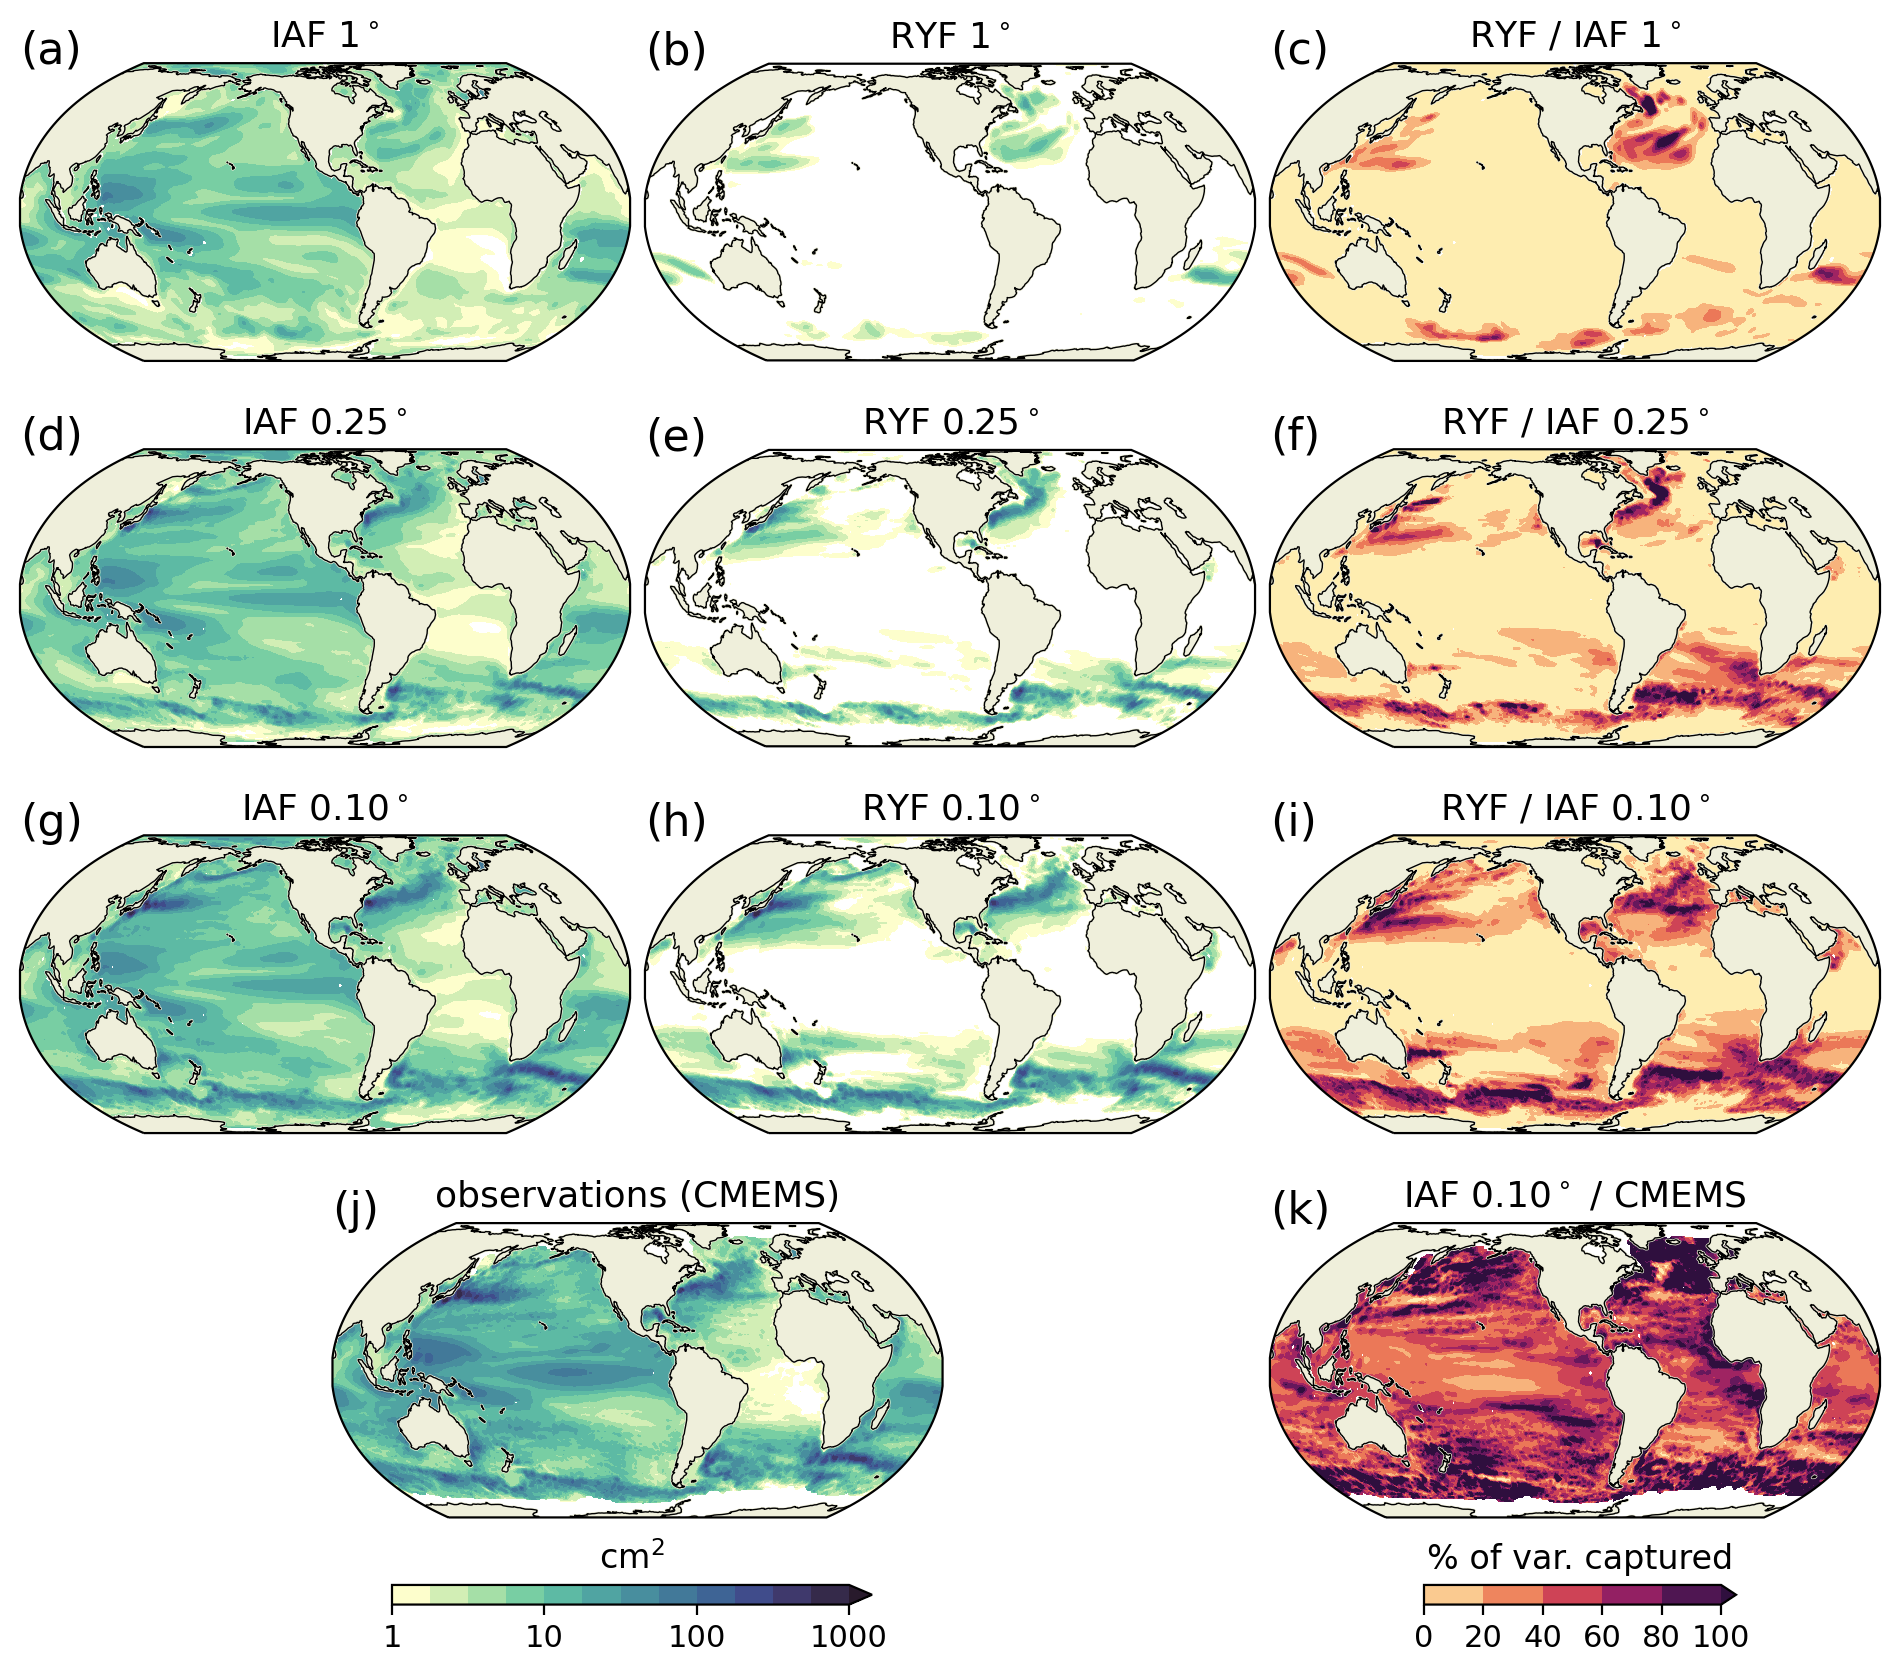

In [20]:
cmapspectra = cmocean.cm.deep
cmapratio = cmocean.cm.matter

projection = ccrs.EqualEarth(central_longitude=-100.0)

fig = plt.figure(figsize=(12, 9.8), constrained_layout=True)

gs = fig.add_gridspec(4, 6, wspace=0.05, hspace=0.1, width_ratios = [1, 1, 1, 1, 1, 1], height_ratios=[1, 1, 1, 1])

ax1  = plt.subplot(gs[0, 0:2], projection=projection)
ax2  = plt.subplot(gs[0, 2:4], projection=projection)
ax3  = plt.subplot(gs[0, 4:6], projection=projection)
ax4  = plt.subplot(gs[1, 0:2], projection=projection)
ax5  = plt.subplot(gs[1, 2:4], projection=projection)
ax6  = plt.subplot(gs[1, 4:6], projection=projection)
ax7  = plt.subplot(gs[2, 0:2], projection=projection)
ax8  = plt.subplot(gs[2, 2:4], projection=projection)
ax9  = plt.subplot(gs[2, 4:6], projection=projection)
ax10 = plt.subplot(gs[3, 1:3], projection=projection)
ax11 = plt.subplot(gs[3, 4:6], projection=projection)

levels = np.logspace(-4, -1, 13)

ssh_1_IAF_avspec.plot.contourf(ax=ax1, levels=levels, extend='max', cmap=cmapspectra, add_labels=False, add_colorbar=False,
                                 transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)

ax1.set_title(r'IAF 1$^\circ$', fontsize=13)


ssh_1_RYF_avspec.plot.contourf(ax=ax2, levels=levels, extend='max', cmap=cmapspectra, add_labels=False, add_colorbar=False,
                                 transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax2.set_title(r'RYF 1$^\circ$', fontsize=13)



ssh_025_IAF_avspec.plot.contourf(ax=ax4, levels=levels, extend='max', cmap=cmapspectra, add_labels=False, add_colorbar=False,
                                   transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax4.set_title(r'IAF 0.25$^\circ$', fontsize=13)


ssh_025_RYF_avspec.plot.contourf(ax=ax5, levels=levels, extend='max', cmap=cmapspectra, add_labels=False, add_colorbar=False,
                                   transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax5.set_title(r'RYF 0.25$^\circ$', fontsize=13)


h=ssh_010_IAF_avspec.plot.contourf(ax=ax7, levels=levels, extend='max', cmap=cmapspectra, add_labels=False, add_colorbar=False,
                                   transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax7.set_title(r'IAF 0.10$^\circ$', fontsize=13)


ssh_010_RYF_avspec.plot.contourf(ax=ax8, levels=levels, extend='max', cmap=cmapspectra, add_labels=False, add_colorbar=False,
                                   transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax8.set_title(r'RYF 0.10$^\circ$', fontsize=13)


ssh_cmems_detrended_avspec.plot.contourf(ax=ax10, levels=levels, extend='max', cmap=cmapspectra, add_labels=False, add_colorbar=False,
                                 transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax10.set_title(r'observations (CMEMS)', fontsize=13)


levelsratio = np.linspace(0, 120, 7)

h2 = (100*ssh_1_RYF_avspec/ssh_1_IAF_avspec).plot.contourf(ax=ax3, levels=levelsratio,
                                                               cmap=cmapratio, add_labels=False, add_colorbar=False,
                                                               transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax3.set_title(r'RYF / IAF 1$^\circ$', fontsize=13)



(100*ssh_025_RYF_avspec/ssh_025_IAF_avspec).plot.contourf(ax=ax6, levels=levelsratio,
                                                              cmap=cmapratio, add_labels=False, add_colorbar=False,
                                                              transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax6.set_title(r'RYF / IAF 0.25$^\circ$', fontsize=13)


(100*ssh_010_RYF_avspec/ssh_010_IAF_avspec).plot.contourf(ax=ax9, levels=levelsratio, cmap=cmapratio, add_labels=False, add_colorbar=False,
                                 transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax9.set_title(r'RYF / IAF 0.10$^\circ$', fontsize=13)


(100*ssh_010_IAF_avisorec_avspec/ssh_cmems_detrended_avspec).plot.contourf(ax=ax11, levels=levelsratio, cmap=cmapratio, add_labels=False, add_colorbar=False,
                                 transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax11.set_title(r'IAF 0.10$^\circ$ / CMEMS', fontsize=13)


cax = plt.axes([0.28, 0.08, 0.2, 0.01])
cbar = plt.colorbar(h, cax=cax, ticks=[1e-4, 1e-3, 1e-2, 1e-1], boundaries=np.arange(10e-5, 10e-2), orientation='horizontal')
cbar.ax.set_xticklabels(['1', '10', '100', '1000'])
cbar.ax.set_title(r'cm$\mathregular{^2}$', fontsize=12)
cbar.ax.tick_params(labelsize=11)

cax2 = plt.axes([0.71, 0.08, 0.13, 0.01])
m = plt.cm.ScalarMappable(cmap=cmapratio)
m.set_array(100*ssh_010_RYF_avspec/ssh_010_IAF_avspec)
m.set_clim(0, 100)
cbar2 = plt.colorbar(m, boundaries=levelsratio, cax=cax2, orientation='horizontal', extend='max')
cbar2.ax.tick_params(labelsize=11)
cbar2.ax.set_xticks(np.linspace(0, 100, 6))
cbar2.ax.set_title(r'% of var. captured', fontsize=12)

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_adjustable('box')
    ax.add_feature(cfeature.LAND)
    ax.coastlines(linewidth=0.5)
    ax.set_rasterization_zorder(-10)
    
for n, ax in enumerate(axs):
    ax.text(0, 1, '('+string.ascii_lowercase[n]+')', transform=ax.transAxes, size=16)
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig("figures/figure1.pdf", bbox_inches = 'tight', pad_inches=0.05, dpi=300)

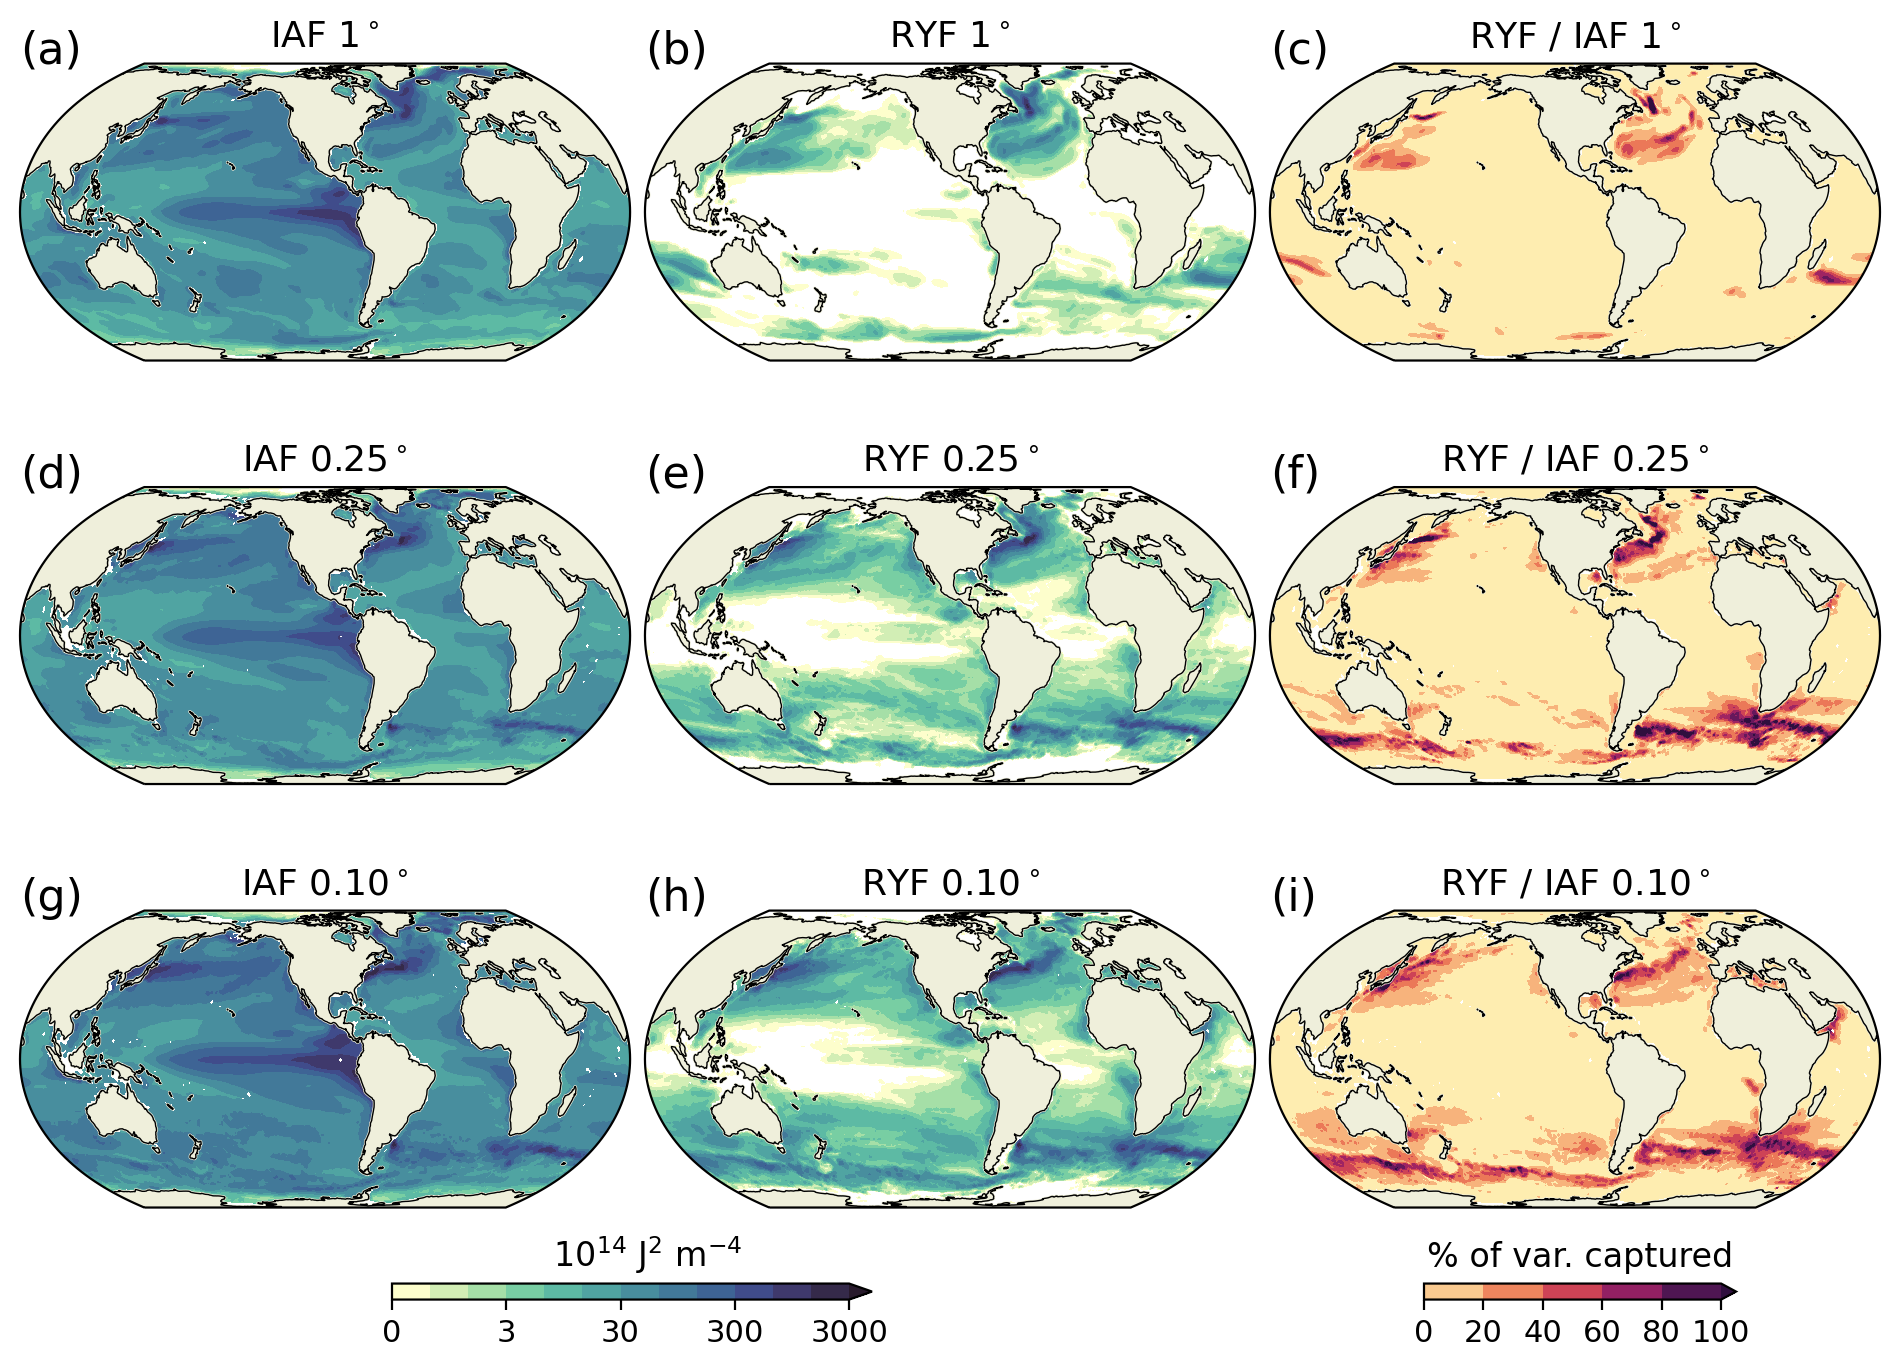

In [21]:
levels = 300*np.logspace(-3, 1, 13)    
ticks = 300*np.logspace(-3, 1, 5)
normaliztion_power = 14

cmapspectra = cmocean.cm.deep
cmapratio = cmocean.cm.matter

normalization_power = 14
normalization = 10**normalization_power

projection = ccrs.EqualEarth(central_longitude=-100.0)

fig = plt.figure(figsize=(12, 8), constrained_layout=True)

gs = fig.add_gridspec(3, 6, wspace=0.05, hspace=0.1, width_ratios = [1, 1, 1, 1, 1, 1], height_ratios=[1, 1, 1])

ax1 = plt.subplot(gs[0, 0:2], projection=projection)
ax2 = plt.subplot(gs[0, 2:4], projection=projection)
ax3 = plt.subplot(gs[0, 4:6], projection=projection)
ax4 = plt.subplot(gs[1, 0:2], projection=projection)
ax5 = plt.subplot(gs[1, 2:4], projection=projection)
ax6 = plt.subplot(gs[1, 4:6], projection=projection)
ax7 = plt.subplot(gs[2, 0:2], projection=projection)
ax8 = plt.subplot(gs[2, 2:4], projection=projection)
ax9 = plt.subplot(gs[2, 4:6], projection=projection)


(uohc_1_IAF_avspec / normalization).plot.contourf(ax=ax1, levels=levels, extend='max', cmap=cmapspectra, add_labels=False, add_colorbar=False,
                                 transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax1.set_title(r'IAF 1$^\circ$', fontsize=13)


(uohc_1_RYF_avspec / normalization).plot.contourf(ax=ax2, levels=levels, extend='max', cmap=cmapspectra, add_labels=False, add_colorbar=False,
                                 transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax2.set_title(r'RYF 1$^\circ$', fontsize=13)

(uohc_025_IAF_avspec / normalization).plot.contourf(ax=ax4, levels=levels, extend='max', cmap=cmapspectra, add_labels=False, add_colorbar=False,
                                   transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax4.set_title(r'IAF 0.25$^\circ$', fontsize=13)


(uohc_025_RYF_avspec / normalization).plot.contourf(ax=ax5, levels=levels, extend='max', cmap=cmapspectra, add_labels=False, add_colorbar=False,
                                   transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax5.set_title(r'RYF 0.25$^\circ$', fontsize=13)

h=(uohc_010_IAF_avspec / normalization).plot.contourf(ax=ax7, levels=levels, extend='max', cmap=cmapspectra, add_labels=False, add_colorbar=False,
                                   transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax7.set_title(r'IAF 0.10$^\circ$', fontsize=13)


(uohc_010_RYF_avspec / normalization).plot.contourf(ax=ax8, levels=levels, extend='max', cmap=cmapspectra, add_labels=False, add_colorbar=False,
                                   transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax8.set_title(r'RYF 0.10$^\circ$', fontsize=13)


levelsratio = np.linspace(0, 120, 7)

h2 = (100*uohc_1_RYF_avspec/uohc_1_IAF_avspec).plot.contourf(ax=ax3, levels=levelsratio,
                                                               cmap=cmapratio, add_labels=False, add_colorbar=False,
                                                               transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax3.set_title(r'RYF / IAF 1$^\circ$', fontsize=13)


(100*uohc_025_RYF_avspec/uohc_025_IAF_avspec).plot.contourf(ax=ax6, levels=levelsratio,
                                                              cmap=cmapratio, add_labels=False, add_colorbar=False,
                                                              transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax6.set_title(r'RYF / IAF 0.25$^\circ$', fontsize=13)


(100*uohc_010_RYF_avspec/uohc_010_IAF_avspec).plot.contourf(ax=ax9, levels=levelsratio, cmap=cmapratio, add_labels=False, add_colorbar=False,
                                 transform=ccrs.PlateCarree(), rasterized=True, zorder=-20)
ax9.set_title(r'RYF / IAF 0.10$^\circ$', fontsize=13)

cax = plt.axes([0.28, 0.08, 0.2, 0.01])
cbar = plt.colorbar(h, cax=cax, orientation='horizontal', ticks=ticks, boundaries=np.arange(ticks[0], ticks[-1]))
cbar.ax.set_title(r'   10$\mathregular{^{'+str(normalization_power)+r'}}$ J$\mathregular{^2}$ m$\mathregular{^{-4}}$', fontsize=12)
cbar.ax.tick_params(labelsize=11)

cax2 = plt.axes([0.71, 0.08, 0.13, 0.01])
m = plt.cm.ScalarMappable(cmap=cmapratio)
m.set_array(uohc_1_RYF_avspec/uohc_1_RYF_avspec)
m.set_clim(0, 100)
cbar2 = plt.colorbar(m, boundaries=levelsratio, cax=cax2, orientation='horizontal', extend='max')
cbar2.ax.tick_params(labelsize=11)
cbar2.ax.set_xticks(np.linspace(0, 100, 6))
cbar2.ax.set_title(r'% of var. captured', fontsize=12)

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for ax in axs:
    ax.add_feature(cfeature.LAND)
    ax.coastlines(linewidth=0.5)
    ax.set_global()
    ax.set_rasterization_zorder(-10)

import string

for n, ax in enumerate(axs):
    ax.text(0, 1, '('+string.ascii_lowercase[n]+')', transform=ax.transAxes, size=16)

plt.subplots_adjust(wspace=0.05, hspace=0)

plt.savefig("figures/figure2.pdf", bbox_inches = 'tight', pad_inches=0.05, dpi=300)

## II. EOF analysis

First define some useful functions for the EOF analysis.

In [22]:
def do_eof_analysis(da, n_eofs):
    """Performs EOF analysis of dataarray `da` and returns the first `n_eofs` (Int) EOFs and PCAs.
    Note that the `eofs` package require the `da` is defined on a regular longitude-latitude grid. """
    
    da_nomean = da - da.mean(dim='time')
    
    coslat = np.cos(np.deg2rad(da.coords['latitude'].values))
    wgts = np.sqrt(coslat)[..., np.newaxis]
    
    solver = Eof(da, weights=wgts)

    eof = solver.eofsAsCovariance(neofs=n_eofs)

    pca = solver.pcs(npcs=n_eofs, pcscaling=1)
    
    variance_fraction = solver.varianceFraction(neigs=n_eofs)
    
    variance_fraction_error = solver.northTest(neigs=n_eofs, vfscaled=True)
    
    total_variance = solver.totalAnomalyVariance()

    return eof, pca, variance_fraction, variance_fraction_error, total_variance

In [23]:
def compute_mean_variance_over_region(da1, da025, da010):
    """Computes the mean variance from three data arrays `da1`, `da025` and `da010`."""
    
    std1 = da1.std(dim='time')
    var1 = sphere_average(std1**2)
    
    std025 = da025.std(dim='time')
    var025 = sphere_average(std025**2)
    
    std010 = da010.std(dim='time')
    var010 = sphere_average(std010**2)
    
    return var1, var025, var010


def compute_total_variance_over_region(da1, da025, da010):
    """Computes the integrated variance from three data arrays `da1`, `da025` and `da010`."""
    
    std1 = da1.std(dim='time')
    var1 = sphere_integral(std1**2)
    
    std025 = da025.std(dim='time')
    var025 = sphere_integral(std025**2)
    
    std010 = da010.std(dim='time')
    var010 = sphere_integral(std010**2)
    
    return var1, var025, var010

In [24]:
def plot_eofvariance(varianceFraction1, varianceFraction025, varianceFraction010, varianceFractionError1, varianceFractionError025, varianceFractionError010, var1, var025, var010, regionstr, axis='none'):
    
    if axis == 'none':
        fig = plt.figure(figsize=(12, 3), constrained_layout=True)
        gs = fig.add_gridspec(1, 2, wspace=0.05, hspace=0.1, width_ratios = [1, 1])
        axs = np.array([plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1])])
    else:
        axs = axis
        
    if regionstr == 'Global':
        titlestr = 'Global EOF analysis'
    else:
        titlestr = 'EOF analysis of ' + regionstr

    axs[0].plot(varianceFraction1.mode, 100*varianceFraction1, color="C0", lw=1, alpha=0.6)
    axs[0].plot(varianceFraction025.mode, 100*varianceFraction025, color="C1", lw=1, alpha=0.6)
    axs[0].plot(varianceFraction010.mode, 100*varianceFraction010, color="C2", lw=1, alpha=0.6)
    axs[0].errorbar(varianceFraction1.mode, 100*varianceFraction1, yerr=100*varianceFractionError1, marker='d', markersize=7, label=r"1$^\circ$", lw=3, alpha=0.6, ls='none')
    axs[0].errorbar(varianceFraction025.mode, 100*varianceFraction025, yerr=100*varianceFractionError025, marker='o', markersize=7, label=r"0.25$^\circ$", lw=3, alpha=0.6, ls='none')
    axs[0].errorbar(varianceFraction010.mode, 100*varianceFraction010, yerr=100*varianceFractionError010, marker='s', markersize=7, label=r"0.10$^\circ$", lw=3, alpha=0.6, ls='none')
    
    axs[0].legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
    axs[0].set_yscale('linear')
    axs[0].set_xlim(-0.5, 9.5)
    axs[0].set_ylim(0, 1.2*np.max([np.max(100*varianceFraction1), np.max(100*varianceFraction025), np.max(100*varianceFraction010)]))
    axs[0].set_xticks(np.linspace(0, 9, 10))
    axs[0].set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    axs[0].set_title('variance (%)', fontsize=14)
    axs[0].set_xlabel('EOF #', fontsize=14)
    axs[0].grid(ls=':')

    scalefactor = 1e27

    axs[1].plot(varianceFraction1.mode, var1/scalefactor*varianceFraction1, color="C0", lw=1, alpha=0.6)
    axs[1].plot(varianceFraction025.mode, var025/scalefactor*varianceFraction025, color="C1", lw=1, alpha=0.6)
    axs[1].plot(varianceFraction010.mode, var010/scalefactor*varianceFraction010, color="C2", lw=1, alpha=0.6)
    axs[1].errorbar(varianceFraction1.mode, var1/scalefactor*varianceFraction1, yerr=var1/scalefactor*varianceFractionError1, marker='d', markersize=7, label=r"1$^\circ$", lw=3, alpha=0.6, ls='none')
    axs[1].errorbar(varianceFraction025.mode, var025/scalefactor*varianceFraction025, yerr=var025/scalefactor*varianceFractionError025, marker='o', markersize=7, label=r"0.25$^\circ$", lw=3, alpha=0.6, ls='none')
    axs[1].errorbar(varianceFraction010.mode, var010/scalefactor*varianceFraction010, yerr=var010/scalefactor*varianceFractionError010, marker='s', markersize=7, label=r"0.10$^\circ$", lw=3, alpha=0.6, ls='none')
    
    axs[1].set_yscale('linear')
    axs[1].set_xlim(-0.5, 9.5)
    axs[1].set_ylim(0, scalefactor**(-1)*1.2*np.max([np.max(var1*varianceFraction1), np.max(var025*varianceFraction025), np.max(var010*varianceFraction010)]))
    axs[1].set_xticks(np.linspace(0, 9, 10))
    axs[1].set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    axs[1].set_title(r'area-integrated variance ($10^{27}$ J$^2$)', fontsize=14)
    axs[1].set_xlabel('EOF #', fontsize=14)
    axs[1].grid(ls=':')

    if axis == 'none':
        plt.savefig("figures/variance-eof-"+depths_integrated+"-"+regionstr+"-revA.pdf", bbox_inches = 'tight', pad_inches = 0.1)

In [25]:
def split_da_for_robustness_check(da):
    """Return two data arrays consisting from the first 60% and last 60% of the time dimension of the original data array `da`.

    Returns:
    da_p1: The first 60% time dimension of `da` (rounded to make sure that includes whole years).
    da_p1: The last 60% time dimension of `da` (rounded to make sure that includes whole years). """

    da_p1 = da.isel(time=slice(0, int(da.time.size/12 * 0.6) * 12))
    da_p2 = da.isel(time=slice(int(da.time.size/12 * 0.4) * 12, None))
    
    return da_p1, da_p2

In [26]:
from scipy.special import gammainc

def yNlu(sn,yN,ci):
    """ compute yN[l] yN[u], that is, the lower and
                upper limit of yN """

    # cdf of chi^2 dist. with 2*sn DOF
    cdf = gammainc(sn,sn*yN)

    # indices that delimit the wedge of the conf. interval
    fl = np.abs(cdf - ci).argmin()
    fu = np.abs(cdf - 1. + ci).argmin()

    return yN[fl], yN[fu]


def spec_error(E, sn, ci=0.95):
    """ Computes confidence interval for one-dimensional spectral
        estimate E.
        Parameters
        ===========
        - sn is the number of spectral realizations;
                it can be either an scalar or an array of size(E)
        - ci = .95 for 95 % confidence interval
        Output
        ==========
        lower (El) and upper (Eu) bounds on E """

    dbin = 0.005
    yN = np.arange(0,2.+dbin, dbin)

    El, Eu = np.empty_like(E), np.empty_like(E)

    try:
        n = sn.size
    except AttributeError:
        n = 0

    if n:

        assert n == E.size, " *** sn has different size than E "

        for i in range(n):
            yNl, yNu = yNlu(sn[i], yN=yN, ci=ci)
            El[i] = E[i]/yNl
            Eu[i] = E[i]/yNu

    else:
        yNl, yNu = yNlu(sn, yN=yN, ci=ci)
        El = E/yNl
        Eu = E/yNu

    return El, Eu

In [27]:
regions = [
    {'longitude': slice(None, None), 'latitude': slice(None, None)},
    {'longitude': slice(-100, 0), 'latitude': slice(20, 75)},
    {'longitude': slice(-70, 10), 'latitude': slice(-75, -10)},
    {'longitude': slice(13, 120), 'latitude':slice(-70, -10)},
    {'longitude': slice(-250, -100), 'latitude': slice(15, 70)}
]

roll_region_coords = [
    True,
    False,
    False,
    True,
    False
]

region_names = [
    'Global',
    'North Atlantic',
    'South Atlantic',
    'Indian Ocean',
    'North Pacific'
]

projections = [
    ccrs.Robinson(central_longitude=-100.0),
    ccrs.Orthographic(central_longitude=-47, central_latitude=35.0),
    ccrs.EqualEarth(central_longitude=-30.0),
    ccrs.EqualEarth(central_longitude=69.0),
    ccrs.Orthographic(central_longitude=180, central_latitude=15.0)
]

axis_extends = [
    'none',
    'none',
    [-75, 20, -70, -9],
    'none',
    'none'
]

eof1_indices = [
    [0, 2],
    [0, 1],
    [0, 2],
    [0, 2],
    [0, 2]
]

eof025_indices = [
    [0, 3],
    [0, 1],
    [0, 1],
    [0, 1],
    [0, 1]
]

eof010_indices = [
    [0, 1],
    [0, 1],
    [0, 1],
    [0, 2],
    [0, 1]
]

scaleexponents = [
    [21, 21],
    [20, 20],
    [20, 20],
    [20, 20],
    [20, 20]
]

def roll_coords(da1, da025, da010, roll_region_coords):
    if roll_region_coords:
        da1   = da1.assign_coords(longitude=(da1.longitude%360)).roll(roll_coords=True, longitude=-280)
        da025 = da025.assign_coords(longitude=(da025.longitude%360)).roll(roll_coords=True, longitude=-280)
        da010 = da010.assign_coords(longitude=(da010.longitude%360)).roll(roll_coords=True, longitude=-280)

    return da1, da025, da010

In [33]:
def plot_pc_spectrum_ax(pc, mode, ax, piece_duration = 55, color='C0', scaleexponent=0, freqperyear=12):

    scalefactor = 10.**scaleexponent
    
    pcfft = analysisfft(pc, freqperyear=freqperyear)
    piece_duration = piece_duration * 12
    piece_offset = piece_duration // 1
    total_pieces = int( (pc.time.size - piece_duration)/piece_offset + 1)
#     print("total pieces", total_pieces)

    pcfft_pieces = np.zeros((piece_duration//2+1, total_pieces))

    for j in np.arange(total_pieces):

        if pc.isel(time = slice(j*piece_offset, j*piece_offset+piece_duration)).time.size == piece_duration:
            pc_piece = pc.isel(time = slice(j*piece_offset, j*piece_offset+piece_duration))
        else:
            pc_piece =  pc.isel(time = slice(-piece_duration, None))
        
#         pc_piece = remove_highfreq(pc_piece, lower_range=lower_range, upper_range=upper_range, freqperyear=12)

        window = scipy.signal.windows.tukey(pc_piece.time.size, 0.25)
        window /= np.sqrt((window**2).sum() / pc_piece.time.size)
        pc_piece = detrend_datarray(pc_piece)
        pc_piece = pc_piece * window

#         print(pc_piece.time.size/12)
#         print(pc_piece.time.isel(time=0).values)
#         print(pc_piece.time.isel(time=-1).values)

#         pcfft_piece = np.abs(np.fft.rfft(pc_piece.values)**2

#         factor_to_convert_time_units_from_months_to_seconds = 12 / (365.25*24*3600) 
#         pcfft_piece = np.fft.rfft(pc_piece.values) * factor_to_convert_time_units_from_months_to_seconds
    
        pcfft_piece = np.fft.rfft(pc_piece.values /  pc_piece.time.size)

        pcfft_piece = 2 * np.abs(pcfft_piece)**2
        pcfft_piece[0] /= 2

#         pcfft_piece = analysisfft(pc_piece, freqperyear=freqperyear)
        pcfft_pieces[:, j] = pcfft_piece

#     ki = pcfft.freq_time.values
#     Ei = pcfft.values

    ki = np.arange(piece_duration//2 + 1) /  piece_duration * freqperyear
    Ei = pcfft_pieces.mean(axis=1)

    sn = 2*pcfft_pieces.shape[1] * np.ones(Ei.size)

    El, Eu = spec_error(Ei, sn, ci=0.95)

    ax.fill_between(ki, El/scalefactor, Eu/scalefactor, color=color, alpha=0.25, rasterized=True)
    ax.semilogx(ki, Ei/scalefactor, color=color)

#     ax.set_xlabel(r"Wavenumber")
#     ax.set_ylabel(r"Spectral density")
    ax.grid('on')
    ax.set_xlim(0.01, 1)
    ax.set_xticks([2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1])

    ax.set_xticklabels(['1/50', '1/20', '1/10', '1/5', '1/2', '1'])
    ax.set_title("")
    if scaleexponent == 0:
        ax.set_ylabel(r"|$\widehat{\;{\rm PC}}$ #"+str(mode+1)+"|$\mathregular{^2}$ \n (J$\mathregular{^2}\,$s$\mathregular{^2}$)", fontsize=14)
        ax.set_ylabel(r"|$\widehat{\;{\rm PC}}$ #"+str(mode+1)+"|$\mathregular{^2}$", fontsize=14)
    else:
        ax.set_ylabel(r"|$\widehat{\;{\rm PC}}$ #"+str(mode+1)+"|$\mathregular{^2}$ \n ($\mathregular{10^{"+str(scaleexponent)+"}}$ J$\mathregular{^2}\,$s$\mathregular{^2}$)", fontsize=14)
        ax.set_ylabel(r"|$\widehat{\;{\rm PC}}$ #"+str(mode+1)+"|$\mathregular{^2}$", fontsize=14)
    ax.set_xlabel("cycles per year", fontsize=14)
    plt.tick_params(direction='out', length=6, width=2, which='major')

In [34]:
rc('text', usetex=False)
plt.rcParams.update({
    "font.family": "sans-serif",
#     "font.serif": [],                    # use latex default serif font
    "font.sans-serif": ["DejaVu Sans"],  # use a specific sans-serif font
})


matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}']

import matplotlib.ticker as ticker

def plot_eof_pc_axs(eof, pc, varfraction, totvar, mode, freqperyear=12, model="ACCESS-OM2", projection=ccrs.EqualEarth(central_longitude=0.0), region='global', ax1='none', ax2='none', extent='none', scaleexponent=0):

    cmapeof = 'RdYlBu_r' #cmocean.cm.balance
#     cmapeof = 'coolwarm'
    cmapeof = cmocean.cm.balance
    cmapeof = 'RdBu_r'
    cmapeof = 'seismic'
    
    if model==r"1$^\circ$":
        color='C0'
    elif model==r"0.25$^\circ$":
        color='C1'
    elif model==r"0.10$^\circ$":
        color='C2'
    
    maxvalue = 0.5 * np.max(np.abs(eof[mode].fillna(0).values))
    levels = np.linspace(-maxvalue, maxvalue, 20)
    dlevel = levels[2]-levels[1]

    if ax1=='none':
        fig = plt.figure(figsize=(5, 4))
        ax1 = plt.axes([0.025, 0.2, 0.95, 0.79], projection=projection)

    if (region=='Indian Ocean' or region=='southatlantoindian'):
        eof[mode].plot.contourf(ax=ax1, extend='both', cmap=cmapeof, add_colorbar=False, levels=levels,
                         transform=ccrs.PlateCarree(), add_labels=False, rasterized=True, zorder=-20)
    else:
        if region=='Global':
            eof[mode].where(np.abs(eof[mode].values)>0.15*dlevel).plot.contourf(ax=ax1, extend='both', cmap=cmapeof, add_colorbar=False, levels=levels,
                         transform=ccrs.PlateCarree(), add_labels=False, rasterized=True, zorder=-20)
        else:
            eof[mode].plot.contourf(ax=ax1, extend='both', cmap=cmapeof, add_colorbar=False, levels=levels,
                 transform=ccrs.PlateCarree(), add_labels=False, rasterized=True, zorder=-20)
    
    ax1.add_feature(cfeature.LAND)

#     ax1.set_title(model+", EOF #"+str(j+1)+", "+str(round(100*var[j].values, 1))+"% var.", fontsize=14)
    ax1.set_title("EOF #"+str(mode+1)+", "+str(round(100*varfraction[mode].values, 1))+"% var.", fontsize=14)
    
    if region=='Global':
        ax1.set_global()
        ax1.coastlines(resolution='110m')
    else:
        ax1.coastlines(resolution='50m')
        
    if extent != 'none':
        ax1.set_extent(extent, crs=ccrs.PlateCarree())
        
    gl = ax1.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)
    
    ax1.set_rasterization_zorder(-10)
    
    params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
    plt.rcParams.update(params)
    
    if ax2=='none':
        ax2 = plt.axes([0.025, 0.01, 0.95, 0.17])
    
    variance_normalization = np.sqrt(totvar.values * varfraction.sel(mode=mode).values)
#     pc = (variance_normalization * pc)

    plot_pc_spectrum_ax(pc.sel(mode=mode), mode, ax2, color=color, scaleexponent=0)
    
#     pcfft = analysisfft(pc.sel(mode=j), freqperyear=freqperyear)
#     ax2.semilogx(pcfft.freq_time, pcfft, color=color, lw=2)
#     ax2.grid('on')
#     ax2.set_xlim(0.01, 1)
#     ax2.set_xlim(0.02, 1)
#     ax2.set_ylim(1e-6, )
#     ax2.set_xticks([2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1])

#     majors = [2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1]
#     ax.xaxis.set_major_locator(ticker.FixedLocator(majors))
#     minors = [3e-2, 4e-2, 6e-2, 7e-2, 8e-2, 9e-2, 3e-1, 4e-1, 6e-1, 7e-1, 8e-1, 9e-1]
#     ax.xaxis.set_minor_locator(ticker.FixedLocator(minors))
    
#     ax2.set_xticklabels(['1/50', '1/20', '1/10', '1/5', '1/2', '1'])
#     ax2.set_title("")
# #     ax2.set_ylabel(r"|$\mathtt{fft}$(PCA #"+str(j+1)+")|$\mathregular{^2}$", fontsize=14)
#     ax2.set_ylabel(r"|$\widehat{\;{\rm PC}}$ #"+str(j+1)+"|$\mathregular{^2}$", fontsize=14)
#     ax2.set_xlabel("cycles per year", fontsize=14)
#     ax2.tick_params(direction='out', length=6, width=2, which='major')
#     ax2.tick_params(direction='out', length=4, width=1, which='minor')
    return ax1, ax2

In [35]:
def plot_eofs_pcas(region):
    width_eof, height_eof = 0.32, 0.20
    width_pca, height_pca = 0.23, 0.08
    hspace_pca = 0.07
    white_h = 0.04

    yloc_var = 0.77
    
    yloc_eofa = yloc_var  - 2.4*white_h - height_eof - 0.02
    yloc_pcaa = yloc_eofa - 0.4*white_h - height_pca
    yloc_eofb = yloc_pcaa - 2.4*white_h - height_eof
    yloc_pcab = yloc_eofb - 0.4*white_h - height_pca

    fig = plt.figure(figsize=(12, 10))

    ax_var1 = plt.axes([0.05, yloc_var, 0.36, 0.12])
    ax_var2 = plt.axes([0.55, yloc_var, 0.36, 0.12])
    
    plot_eofvariance(varianceFraction1, varianceFraction025, varianceFraction010, varianceFractionError1, varianceFractionError025, varianceFractionError010, var1, var025, var010, region_names[region_index], axis=[ax_var1, ax_var2])

    ax_eof1a   = plt.axes([0.00, yloc_eofa, width_eof, height_eof], projection=projection)
    ax_eof025a = plt.axes([0.34, yloc_eofa, width_eof, height_eof], projection=projection)
    ax_eof010a = plt.axes([0.68, yloc_eofa, width_eof, height_eof], projection=projection)

    ax_pca1a   = plt.axes([0.0+hspace_pca, yloc_pcaa, width_pca, height_pca])
    ax_pca025a = plt.axes([0.34+hspace_pca, yloc_pcaa, width_pca, height_pca])#, sharey=ax_pca1a)
    ax_pca010a = plt.axes([0.68+hspace_pca, yloc_pcaa, width_pca, height_pca])#, sharey=ax_pca1a)

    ax_eof1b   = plt.axes([0.00, yloc_eofb, width_eof, height_eof], projection=projection)
    ax_eof025b = plt.axes([0.34, yloc_eofb, width_eof, height_eof], projection=projection)
    ax_eof010b = plt.axes([0.68, yloc_eofb, width_eof, height_eof], projection=projection)

    ax_pca1b   = plt.axes([0.00+hspace_pca, yloc_pcab, width_pca, height_pca])
    ax_pca025b = plt.axes([0.34+hspace_pca, yloc_pcab, width_pca, height_pca])#, sharey=ax_pca1b)
    ax_pca010b = plt.axes([0.68+hspace_pca, yloc_pcab, width_pca, height_pca])#, sharey=ax_pca1b)
    
    plot_eof_pc_axs(eof1,   pc1,   varianceFraction1,   var1,   eof1_index[0],   freqperyear=12, model=r"1$^\circ$",    projection=projection, region=region, ax1 = ax_eof1a,   ax2 = ax_pca1a,   extent=extent, scaleexponent=scaleexponent[0])
    plot_eof_pc_axs(eof025, pc025, varianceFraction025, var025, eof025_index[0], freqperyear=12, model=r"0.25$^\circ$", projection=projection, region=region, ax1 = ax_eof025a, ax2 = ax_pca025a, extent=extent, scaleexponent=scaleexponent[0])
    plot_eof_pc_axs(eof010, pc010, varianceFraction010, var010, eof010_index[0], freqperyear=12, model=r"0.10$^\circ$", projection=projection, region=region, ax1 = ax_eof010a, ax2 = ax_pca010a, extent=extent, scaleexponent=scaleexponent[0])

    a_number = np.max([np.max(analysisfft(pc1).sel(mode=eof1_index[0]).values), np.max(analysisfft(pc025).sel(mode=eof025_index[0]).values), np.max(analysisfft(pc010).sel(mode=eof010_index[0]).values)])
    significant_digits = 1
    rounded_number =  round(a_number, significant_digits - int(math.floor(math.log10(abs(a_number)))) - 1)

    plot_eof_pc_axs(eof1,   pc1,   varianceFraction1,   var1,   eof1_index[1],   freqperyear=12, model=r"1$^\circ$",    projection=projection, region=region, ax1 = ax_eof1b,   ax2 = ax_pca1b,   extent=extent, scaleexponent=scaleexponent[1])
    plot_eof_pc_axs(eof025, pc025, varianceFraction025, var025, eof025_index[1], freqperyear=12, model=r"0.25$^\circ$", projection=projection, region=region, ax1 = ax_eof025b, ax2 = ax_pca025b, extent=extent, scaleexponent=scaleexponent[1])
    plot_eof_pc_axs(eof010, pc010, varianceFraction010, var010, eof010_index[1], freqperyear=12, model=r"0.10$^\circ$", projection=projection, region=region, ax1 = ax_eof010b, ax2 = ax_pca010b, extent=extent, scaleexponent=scaleexponent[1])

    a_number = np.max([np.max(analysisfft(pc1).sel(mode=eof1_index[1]).values), np.max(analysisfft(pc025).sel(mode=eof025_index[1]).values), np.max(analysisfft(pc010).sel(mode=eof010_index[1]).values)])
    significant_digits = 1
    rounded_number =  round(a_number, significant_digits - int(math.floor(math.log10(abs(a_number)))) - 1)

    ax_eof1a.annotate(r'RYF 1$^\circ$', xy=(0.42, 1.05), xycoords='axes fraction',
                xytext=(20, 20), textcoords='offset points',
                ha="center", va="bottom",
                color='C0',
                fontweight='medium',
                fontsize=18)

    ax_eof025a.annotate(r'RYF 0.25$^\circ$', xy=(0.44, 1.05), xycoords='axes fraction',
                xytext=(20, 20), textcoords='offset points',
                ha="center", va="bottom",
                color='C1',
                fontweight='medium',
                fontsize=18)

    ax_eof010a.annotate(r'RYF 0.10$^\circ$', xy=(0.44, 1.05), xycoords='axes fraction',
                xytext=(20, 20), textcoords='offset points',
                ha="center", va="bottom",
                color='C2',
                fontweight='medium',
                fontsize=18)
    
    axs = [ax_eof1a, ax_eof025a, ax_eof010a, ax_eof1b, ax_eof025b, ax_eof010b]
    
    ax_var1.annotate('('+string.ascii_lowercase[0]+')',
            xy=(-0.08, 1.3),
            xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='top',
            textcoords='axes fraction',
            transform=ax_var1.transAxes,
            fontsize=16)

    ax_var2.annotate('('+string.ascii_lowercase[1]+')',
            xy=(-0.08, 1.3),
            xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='top',
            textcoords='axes fraction',
            transform=ax_var1.transAxes,
            fontsize=16)

    for n, ax in enumerate(axs):
        ax.annotate('('+string.ascii_lowercase[n+2]+')',
                    xy=(-0.04, 1.12),
                    xycoords='figure fraction',
                    horizontalalignment='left',
                    verticalalignment='top',
                    textcoords='axes fraction',
                    transform=ax.transAxes,
                    fontsize=16)

    if region == 'Global':
        titlestr = 'Global EOF analysis'
    else:
        titlestr = 'EOF analysis of ' + region

    fig.suptitle(titlestr, fontsize=18)

    plt.savefig("figures/eofs_pcas_combined_"+region+".pdf", bbox_inches='tight', pad_inches=0.1, dpi=400)

In [ ]:
n_eofs = 10

for region_index in np.arange(len(regions)):
    
    region = regions[region_index]
    region_name = region_names[region_index]
    extent = axis_extends[region_index]
    
    eof1_index   = eof1_indices[region_index]
    eof025_index = eof025_indices[region_index]
    eof010_index = eof010_indices[region_index]
    
    scaleexponent = scaleexponents[region_index]
    
    da1   = uohc_1_RYF_LF
    da025 = uohc_025_RYF_LF
    da010 = uohc_010_RYF_LF

    da1, da025, da010 = roll_coords(da1, da025, da010, roll_region_coords[region_index])
    
    da1   = da1.sel(region)
    da025 = da025.sel(region)
    da010 = da010.sel(region)

    print('performing EOF analysis: ', region_name, '...')
    
    var1, var025, var010 = compute_total_variance_over_region(da1, da025, da010)
    
    eof1,   pc1,   varianceFraction1,   varianceFractionError1,   total_variance1   = do_eof_analysis(da1,   n_eofs)
    eof025, pc025, varianceFraction025, varianceFractionError025, total_variance025 = do_eof_analysis(da025, n_eofs)
    eof010, pc010, varianceFraction010, varianceFractionError010, total_variance010 = do_eof_analysis(da010, n_eofs)

    projection = projections[region_index]
        
    print('performing EOF analysis: ', region_name, '... DONE')
    print('plotting figures...')
    
    plot_eofs_pcas(region_name)

performing EOF analysis:  Global ...
performing EOF analysis:  Global ... DONE
plotting figures...
performing EOF analysis:  North Atlantic ...
performing EOF analysis:  North Atlantic ... DONE
plotting figures...
performing EOF analysis:  South Atlantic ...
performing EOF analysis:  South Atlantic ... DONE
plotting figures...
performing EOF analysis:  Indian Ocean ...
performing EOF analysis:  Indian Ocean ... DONE
plotting figures...
performing EOF analysis:  North Pacific ...
performing EOF analysis:  North Pacific ... DONE
plotting figures...
performing EOF analysis:  Pacific Ocean ...


#### Packages used in notebook

In [ ]:
%load_ext watermark

In [ ]:
%watermark --iversions